In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
import xarray as xr

import common.loss_utils as loss_utils
import common.climatehack_dataset as climatehack_dataset 

import sys
sys.path.append('./dgmr')
import dgmr


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
SATELLITE_ZARR_PATH = 'data/full/eumetsat_seviri_hrv_uk.zarr/'

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

print(dataset)

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>


In [6]:
test = np.load('data/test.npz')
test_times = test['times']

In [7]:
import pandas as pd
skip = set()
for t in test_times:
    d = pd.Timestamp(t).date()
    skip.add(d.strftime('%Y-%m-%d'))
len(skip)

30

In [8]:
import datetime
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2021, 11, 7)
cur = start_date
days_to_get = []
while cur != end_date + datetime.timedelta(days=1):
    if cur.strftime('%Y-%m-%d') not in skip:
        days_to_get.append(cur)
    cur = cur + datetime.timedelta(days=1)

In [9]:
def get_day_slice(date):    
    # get data from 10:00 to 16:00 on this day
    data_slice = dataset.loc[
        {
            "time": slice(
                date + datetime.timedelta(hours=10),
                date + datetime.timedelta(hours=16),
            )
        }
    ]
    return data_slice

slices = []
for date in days_to_get:
    slc = get_day_slice(date)
    slices.append(slc)
combined = xr.concat(slices, dim='time')
del dataset

In [10]:
torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(240.3414, 146.52366),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [11]:
BATCH_SIZE = 16
ds = climatehack_dataset.ClimatehackDataset(
    combined,
    days=days_to_get,
    crops_per_slice=8,
    transform=tsfm,
    random_state=7,
)
ch_dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    prefetch_factor=4,
)

In [12]:
x, y = ds[0]

In [13]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 64, 64]))

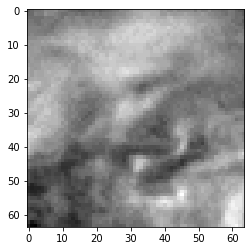

In [14]:
plt.imshow(x[-1,32:96,32:96], cmap='gray')

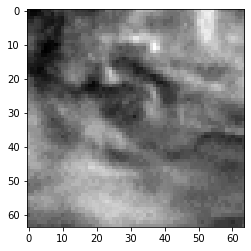

In [15]:
plt.imshow(y[0], cmap='gray')

In [12]:
model = dgmr.DGMR(
    forecast_steps=FORECAST,
    input_channels=1,
    output_shape=128,
    latent_channels=384,
    context_channels=192,
    num_samples=3,
)
model = model.to(DEVICE)
model.load_state_dict(torch.load('weights/300d_dgmr_full/dgmr_epochs=13_batch=899_loss=0.1847.pt'))

<All keys matched successfully>

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 58104267 trainable parameters


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_criterion = torch.nn.MSELoss()

In [15]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()
    final_layer = torch.nn.AvgPool2d(kernel_size=2)

    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs.float().to(DEVICE)
        # add a dimension because 1D image
        x = torch.unsqueeze(x, dim=2)
        y = torch.unsqueeze(y, dim=2)

        preds = model(x)
        b, t, c, h, w = preds.shape
        preds = preds.reshape(b, t*c, h, w)
        preds = final_layer(preds)
        preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
        loss = criterion(preds, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            
    return epoch_loss / total_count



In [ ]:
EPOCHS = 100
EXISTING = 13

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, ch_dataloader, optimizer, mse_criterion)
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/300d_dgmr_full/dgmr_epochs={i}_loss={avg_loss}.pt')
    

Epoch 14


  0%|          | 0/324 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Loss, Batch Loss: (0.2931, 0.6463): 100%|██████████| 324/324 [15:37<00:00,  2.89s/it]


Epoch 15


Avg Loss, Batch Loss: (0.276, 1.5081): 100%|██████████| 324/324 [15:48<00:00,  2.93s/it] 


Epoch 16


Avg Loss, Batch Loss: (0.2777, 0.3023): 100%|██████████| 324/324 [15:52<00:00,  2.94s/it]


Epoch 17


Avg Loss, Batch Loss: (0.288, 0.6631): 100%|██████████| 324/324 [15:53<00:00,  2.94s/it] 


Epoch 18


Avg Loss, Batch Loss: (0.2766, 0.2159): 100%|██████████| 324/324 [15:52<00:00,  2.94s/it]


Epoch 19


Avg Loss, Batch Loss: (0.2787, 0.2653): 100%|██████████| 324/324 [15:54<00:00,  2.95s/it]


Epoch 20


Avg Loss, Batch Loss: (0.2711, 0.2486): 100%|██████████| 324/324 [15:50<00:00,  2.93s/it]


Epoch 21


Avg Loss, Batch Loss: (0.281, 0.116): 100%|██████████| 324/324 [15:51<00:00,  2.94s/it]  


Epoch 22


Avg Loss, Batch Loss: (0.2657, 0.5533): 100%|██████████| 324/324 [15:50<00:00,  2.93s/it]


Epoch 23


Avg Loss, Batch Loss: (0.2733, 0.4037): 100%|██████████| 324/324 [15:50<00:00,  2.93s/it]


Epoch 24


Avg Loss, Batch Loss: (0.2825, 0.5076): 100%|██████████| 324/324 [15:50<00:00,  2.93s/it]


Epoch 25


Avg Loss, Batch Loss: (0.2615, 0.2476): 100%|██████████| 324/324 [15:52<00:00,  2.94s/it]


Epoch 26


Avg Loss, Batch Loss: (0.2745, 0.2342): 100%|██████████| 324/324 [15:51<00:00,  2.94s/it]


Epoch 27


Avg Loss, Batch Loss: (0.2671, 0.1333):  80%|███████▉  | 258/324 [12:38<03:13,  2.93s/it]

In [12]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [13]:
LOOKS = int(500/BATCH_SIZE)

In [15]:
final_layer = torch.nn.AvgPool2d(kernel_size=2)
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(ch_dataloader, total=LOOKS)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.float().to(DEVICE)
    y = trgs.float().to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    with torch.no_grad():
        preds = model(x)
        
    b, t, c, h, w = preds.shape
    preds = preds.reshape(b, t*c, h, w)
    preds = final_layer(preds)
    preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
    preds = torch.tanh(preds)
    
    y = torch.atanh(y) * _IQR + _MEDIAN_PIXEL
    preds = torch.atanh(preds) * _IQR + _MEDIAN_PIXEL
    score = get_mssim(preds, y, average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')
    

  0%|          | 0/31 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/31 [00:43<?, ?it/s]


NameError: name '_IQR' is not defined

In [19]:
scores = np.array(scores)
scores.mean()

0.7331403812859207

In [20]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.81953028, 0.80779251, 0.7925936 , 0.77860733, 0.76632544,
       0.75560664, 0.74665596, 0.73973686, 0.73300125, 0.72682996,
       0.7219309 , 0.7180197 , 0.7147535 , 0.71201834, 0.71078821,
       0.7092426 , 0.70752272, 0.70651771, 0.70536642, 0.7044202 ,
       0.70426552, 0.70410484, 0.70460211, 0.70513655])

In [21]:
step = np.array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [26]:
choice = 4
np.array(step[:choice].tolist() + step_dgmr[choice:].tolist()).mean()

0.744191275606158

In [27]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

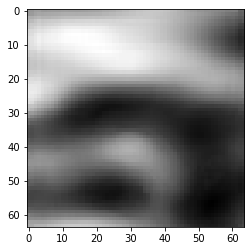

In [32]:
plt.imshow(out[0,0], cmap='gray')

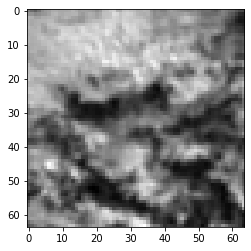

In [33]:
plt.imshow(true[0,0], cmap='gray')

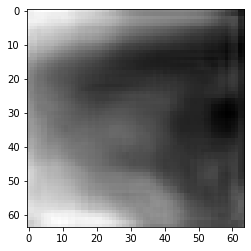

In [30]:
plt.imshow(out[0,-1], cmap='gray')

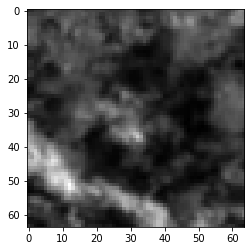

In [31]:
plt.imshow(true[0,-1], cmap='gray')